In [1]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
import imageio
%matplotlib inline
from ipywidgets import interactive, widgets
import time

In [2]:
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-01-17 05:17:02--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-01-17 05:17:03--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz.1’

tiny_nerf_data.npz. 100%[===================>]  12.14M  6.83MB/s    in 1.8s    

2024-01-17 05:17:05 (6.83 MB/s) - ‘tiny_nerf_data.npz.1’ saved [12727482/12727482]



In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Print the exception if memory growth setting fails
        print(e)

Images shape:  (106, 100, 100, 3)
Poses shape:  (106, 4, 4)


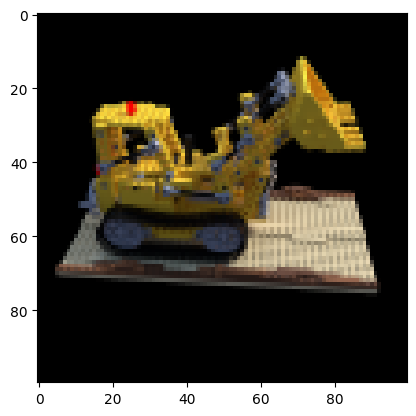

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print("Images shape: ", images.shape)
print("Poses shape: ", poses.shape)

testimg, testpose = images[90], poses[90]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [5]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity



def init_model(D=2, W=256, L_embed=L_embed):
    """
    Initialize a TensorFlow model.

    Parameters:
    D (int): Number of dense layers in the model.
    W (int): Width of each dense layer (number of neurons).
    L_embed (int): Embedding length, used in the input shape calculation.

    Returns:
    tf.keras.Model: A TensorFlow Keras model.
    """

    # Define a ReLU activation function
    relu = tf.keras.layers.ReLU()

    # A helper function to create dense layers with specified width and activation
    def dense_layer(W=W, activation=relu):
        return tf.keras.layers.Dense(W, activation=activation)

    # Define the input shape: 3 features + 3*2*L_embed for embeddings
    input_shape = (3 + 3*2*L_embed,)
    inputs = tf.keras.Input(shape=input_shape)

    # Initialize outputs variable with the input layer
    outputs = inputs

    # Add 'D' dense layers to the model
    for i in range(D):
        outputs = dense_layer()(outputs)

        # Every 4th layer (excluding the first), concatenate the outputs with the inputs
        if i % 4 == 0 and i > 0:
            outputs = tf.concat([outputs, inputs], axis=-1)

    # Add a final dense layer with 4 units and no activation function
    outputs = dense_layer(W=4, activation=None)(outputs)

    # Create the Keras model with the specified inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model





def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    # Prevent NaNs in weights
    weights += 1e-5
    # Compute PDF
    pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)
    # Compute CDF
    cdf = tf.cumsum(pdf, axis=-1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)

    # Take uniform samples
    if det:
        u = tf.linspace(0.0, 1.0, N_samples)
        u = tf.broadcast_to(u, tf.concat([tf.shape(cdf)[:-1], [N_samples]], axis=0))
    else:
        u = tf.random.uniform(shape=tf.concat([tf.shape(cdf)[:-1], [N_samples]], axis=0))

    # For testing, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = tf.concat([tf.shape(cdf)[:-1], [N_samples]], axis=0).numpy().tolist()
        u = np.random.rand(*new_shape) if not det else np.linspace(0., 1., N_samples)
        u = np.broadcast_to(u, new_shape)
        u = tf.convert_to_tensor(u, dtype=tf.float32)

    # Invert CDF
    inds = tf.searchsorted(cdf, u, side='right')
    below = tf.maximum(inds - 1, 0)
    above = tf.minimum(inds, tf.shape(cdf)[-1] - 1)
    inds_g = tf.stack([below, above], axis=-1)

    # Gather the bins and CDF values
    matched_shape = tf.concat([tf.shape(inds_g)[:-1], [tf.shape(cdf)[-1]]], axis=0)
    cdf_g = tf.gather(cdf, inds_g, batch_dims=len(inds_g.shape)-2, axis=-1)
    bins_g = tf.gather(bins, inds_g, batch_dims=len(inds_g.shape)-2, axis=-1)

    # Linear interpolation
    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


# def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
#     # Prevent NaNs
#     weights += 1e-5
#     # Compute PDF
#     pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)
#     # Compute CDF
#     cdf = tf.cumsum(pdf, axis=-1)
#     cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)

#     # Take uniform samples
#     if det:
#         u = tf.linspace(0., 1., N_samples)
#         u = tf.broadcast_to(u, tf.concat([tf.shape(cdf)[:-1], [N_samples]], axis=0))
#     else:
#         u = tf.random.uniform(shape=tf.concat([tf.shape(cdf)[:-1], [N_samples]], axis=0))

#     # For testing, overwrite u with numpy's fixed random numbers
#     if pytest:
#         np.random.seed(0)
#         new_shape = tf.concat([tf.shape(cdf)[:-1], [N_samples]], axis=0).numpy().tolist()
#         u = np.random.rand(*new_shape) if not det else np.linspace(0., 1., N_samples)
#         u = np.broadcast_to(u, new_shape)
#         u = tf.convert_to_tensor(u, dtype=tf.float32)

#     # Invert CDF
#     inds = tf.searchsorted(cdf, u, side='right')
#     below = tf.maximum(inds - 1, 0)
#     above = tf.minimum(inds, tf.shape(cdf)[-1] - 1)
#     inds_g = tf.stack([below, above], axis=-1)

#     # Gather the bins and CDF values
#     matched_shape = tf.concat([tf.shape(inds_g)[:-1], [tf.shape(cdf)[-1]]], axis=0)
#     cdf_g = tf.gather(cdf, inds_g, batch_dims=len(inds_g.shape)-2, axis=-1)
#     bins_g = tf.gather(bins, inds_g, batch_dims=len(inds_g.shape)-2, axis=-1)

#     # Linear interpolation
#     denom = cdf_g[..., 1] - cdf_g[..., 0]
#     denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
#     t = (u - cdf_g[..., 0]) / denom
#     samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

#     return samples


# def sample_pdf(bins, weights, N_samples, rand=True):
#     """
#     Samples points from a distribution defined by the provided weights.

#     Args:
#     bins (tf.Tensor): The midpoints of bins of shape (..., N), where N is the number of bins.
#     weights (tf.Tensor): The weights of each bin of shape (..., N).
#     N_samples (int): Number of points to sample.
#     rand (bool): If True, random sampling is used. If False, uniform sampling.

#     Returns:
#     tf.Tensor: Sampled points.
#     """
#     # Normalize weights to form a PDF and compute the CDF
#     weights += 1e-5  # prevent division by zero
#     pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)
#     cdf = tf.cumsum(pdf, axis=-1)
#     cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)  # pad with a zero

#     # Uniformly sample values from the CDF
#     if rand:
#         u = tf.random.uniform(shape=list(cdf.shape[:-1]) + [N_samples])
#     else:
#         u = tf.linspace(0.0, 1.0, N_samples)
#         u = tf.broadcast_to(u, shape=list(cdf.shape[:-1]) + [N_samples])

#     # Find indices where the sampled values would be inserted to maintain the order
#     indices = tf.searchsorted(cdf, u, side="right")
#     below = tf.maximum(0, indices - 1)
#     above = tf.minimum(cdf.shape[-1] - 1, indices)

#     # Gather matched cdf and bins values
#     cdf_below = tf.gather(cdf, below, batch_dims=len(cdf.shape) - 1)
#     cdf_above = tf.gather(cdf, above, batch_dims=len(cdf.shape) - 1)
#     bins_below = tf.gather(bins, below, batch_dims=len(bins.shape) - 1)
#     bins_above = tf.gather(bins, above, batch_dims=len(bins.shape) - 1)

#     # Linearly interpolate the bins values
#     denom = (cdf_above - cdf_below)
#     denom = tf.where(tf.abs(denom) < 1e-5, tf.ones_like(denom), denom)
#     weight = (u - cdf_below) / denom
#     samples = bins_below + weight * (bins_above - bins_below)

#     return samples


def render_rays(network_fn, network_query_fn, rays_o, rays_d, near, far, N_samples, batch_size, N_importance=0, rand=True, perturb=0.):

    def batchify(fn, inputs, chunk=batch_size):
        output = []
        for i in range(0, inputs.shape[0], chunk):
            output.append(fn(inputs[i:i+chunk]))
        return tf.concat(output, 0)

    # Compute 3D query points for initial samples
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples


    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Run network for initial samples
    pts_flat = tf.reshape(pts, [-1, 3])
    pts_flat = network_query_fn(pts_flat)  # Apply embedding function
    raw = batchify(network_fn, pts_flat)
    expected_shape = list(pts.shape[:-1]) + [4]

    if tf.size(raw) == tf.reduce_prod(expected_shape):
        raw = tf.reshape(raw, expected_shape)
    else:
        raise ValueError("Shape mismatch: Cannot reshape raw tensor of shape {} to {}".format(raw.shape, expected_shape))


    # Hierarchical sampling
    if N_importance > 0:
        # Compute weights for hierarchical sampling
        sigma_a = tf.nn.relu(raw[..., 3])
        dists = z_vals[..., 1:] - z_vals[..., :-1]
        dists = tf.concat([dists, tf.broadcast_to([1e10], dists[..., :1].shape)], -1)
        alpha = 1.0 - tf.exp(-sigma_a * dists)
        weights = alpha * tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True)

        # Sample additional points
        z_vals_mid = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], N_importance, rand)
        z_vals = tf.concat([z_vals, z_samples], -1)
        z_vals = tf.sort(z_vals, axis=-1)


        # Query network with additional points
        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
        pts_flat = tf.reshape(pts, [-1, 3])
        pts_flat = network_query_fn(pts_flat)
        raw = batchify(network_fn,pts_flat)
        # rehsape raw into pts shape
        expected_shape = list(pts.shape[:-1]) + [4]
        raw = tf.reshape(raw, expected_shape)

    # Compute final outputs
    sigma_a = tf.nn.relu(raw[..., 3])
    rgb = tf.math.sigmoid(raw[..., :3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map


0 0.7180995368957519 secs per iter


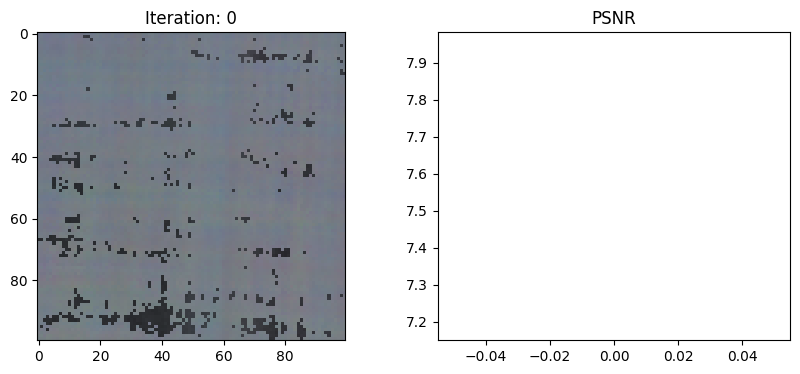

25 2.8083638381958007 secs per iter


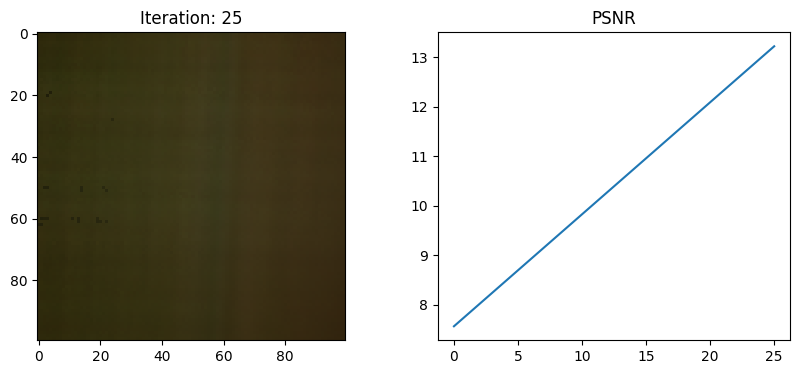

50 2.7488042736053466 secs per iter


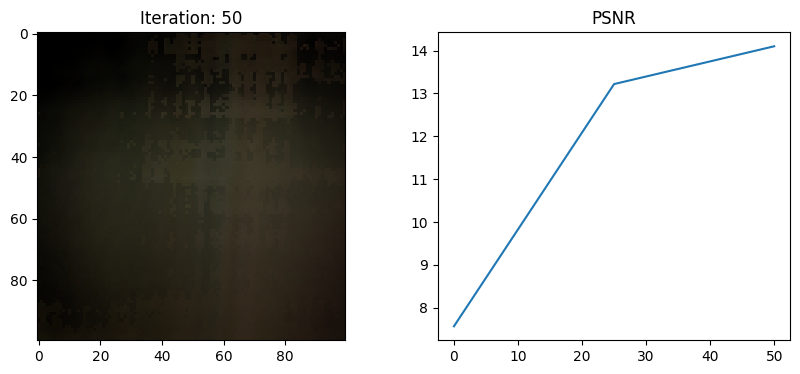

75 2.6998691177368164 secs per iter


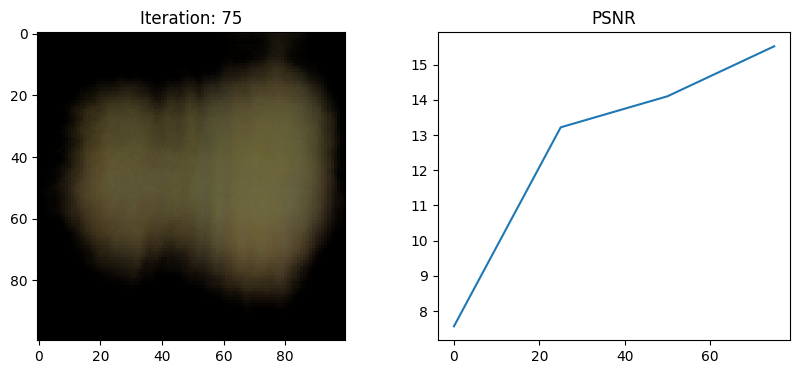

100 2.6982640171051027 secs per iter


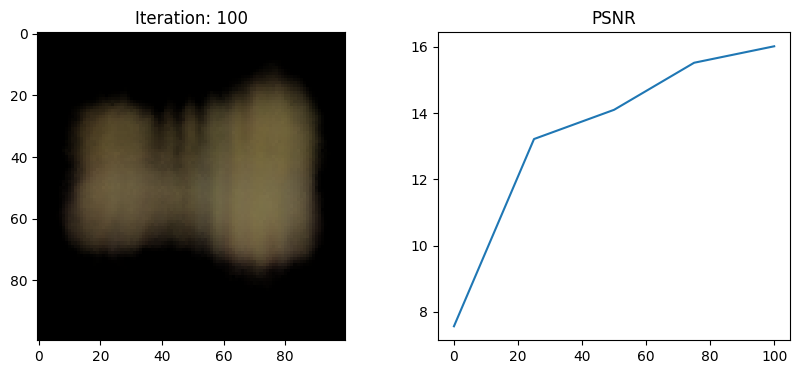

125 2.70319411277771 secs per iter


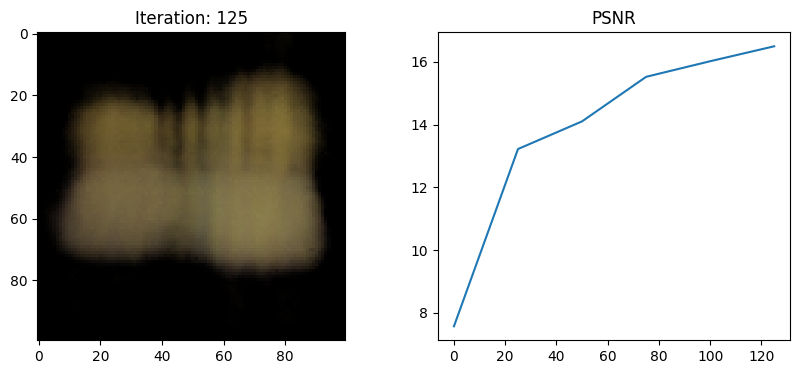

150 3.1160102462768555 secs per iter


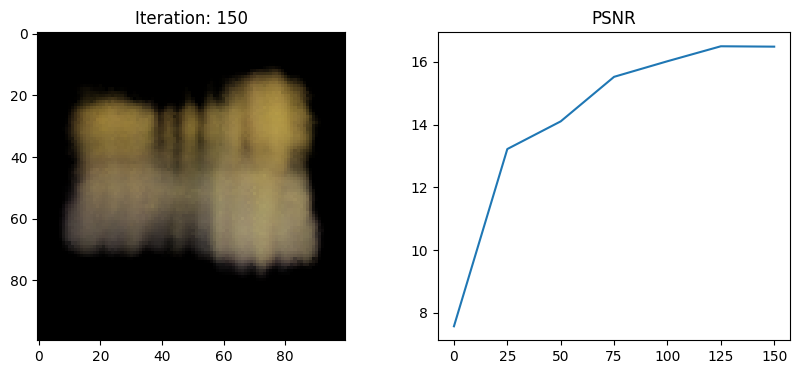

175 2.729576463699341 secs per iter


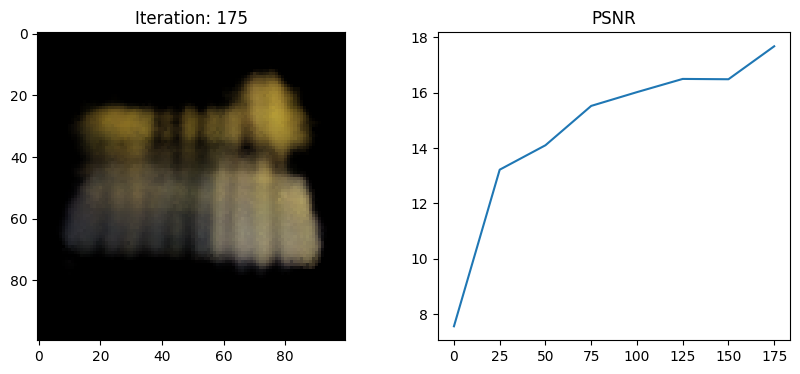

200 2.787749671936035 secs per iter


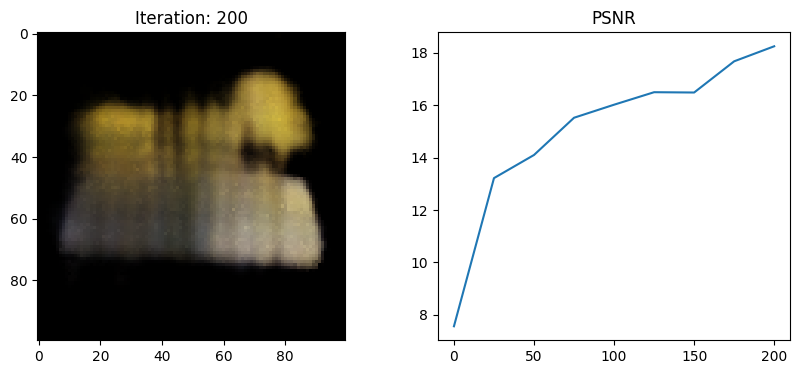

225 2.6993933391571043 secs per iter


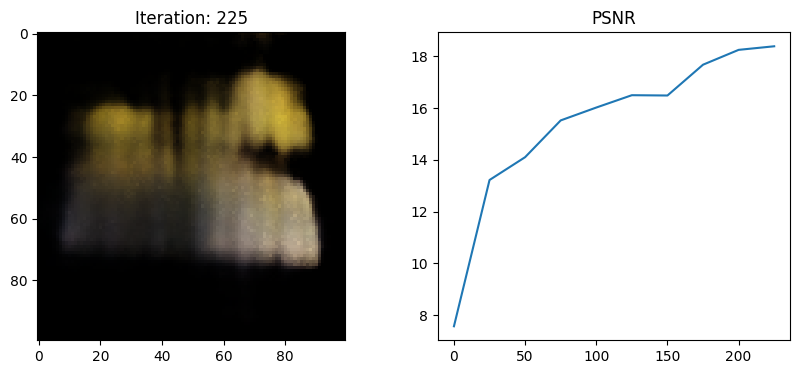

250 2.7151503562927246 secs per iter


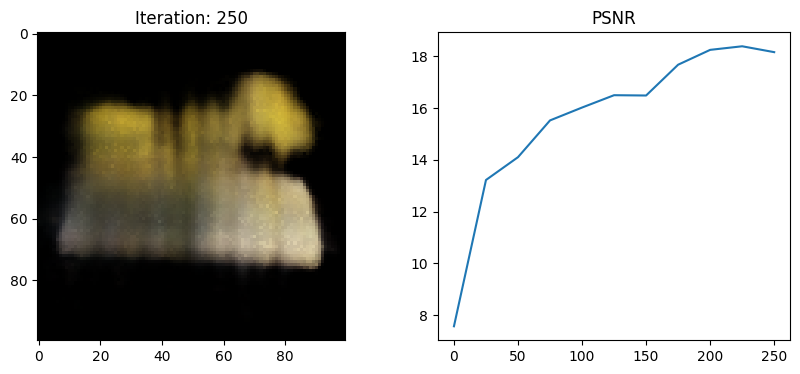

275 2.7405159759521482 secs per iter


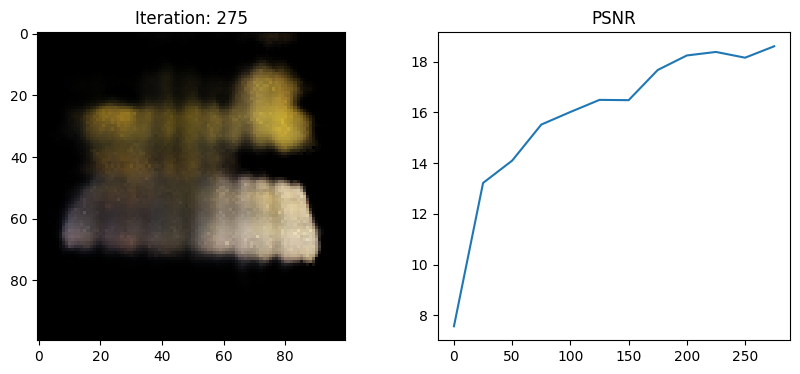

300 2.7211779499053956 secs per iter


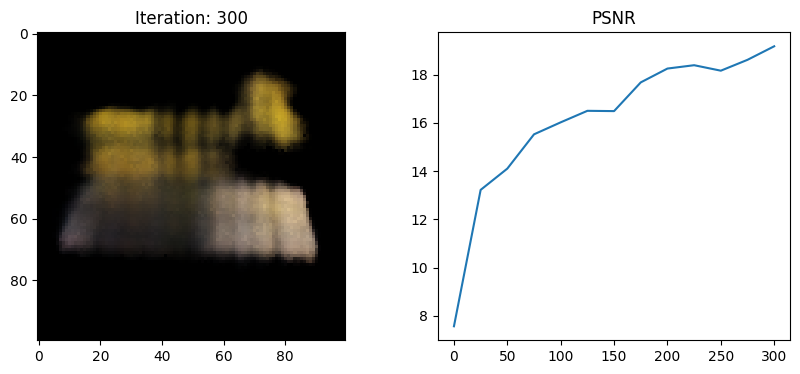

325 2.721299619674683 secs per iter


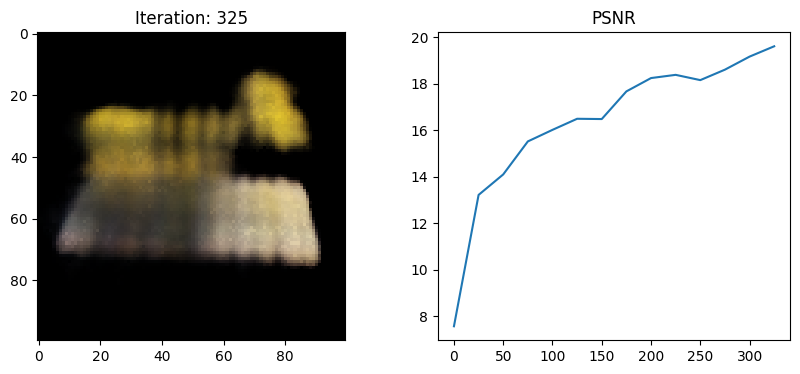

350 2.7459042263031006 secs per iter


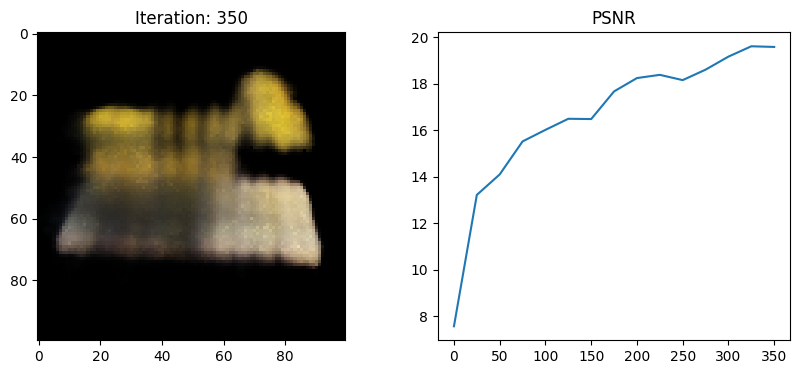

375 2.7534711360931396 secs per iter


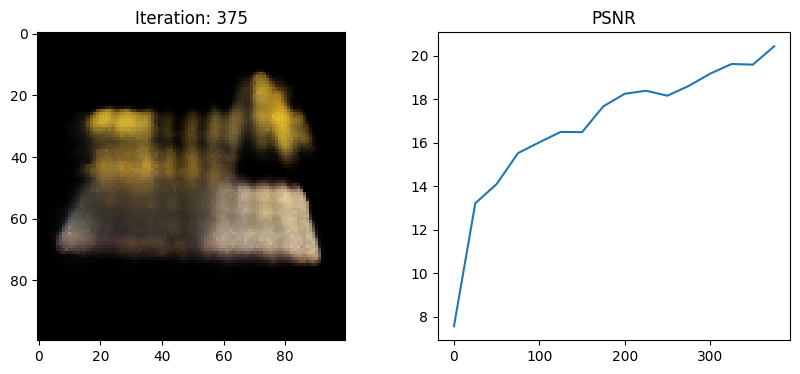

400 2.717053966522217 secs per iter


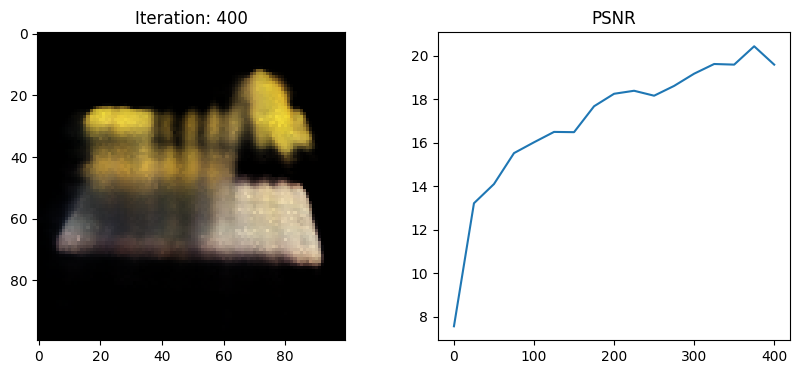

425 2.775141353607178 secs per iter


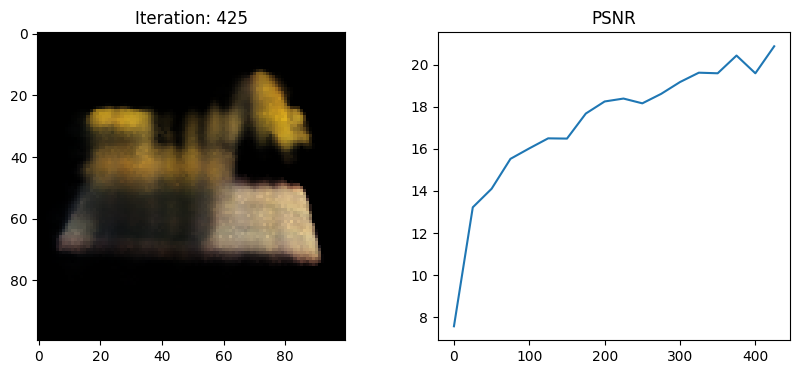

450 2.7472736930847166 secs per iter


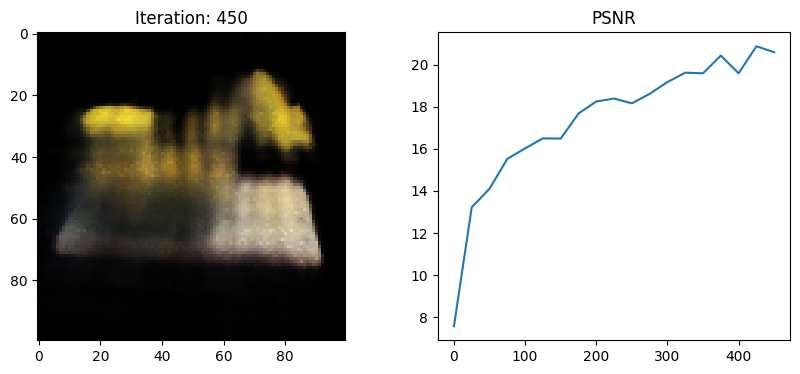

475 2.7653182315826417 secs per iter


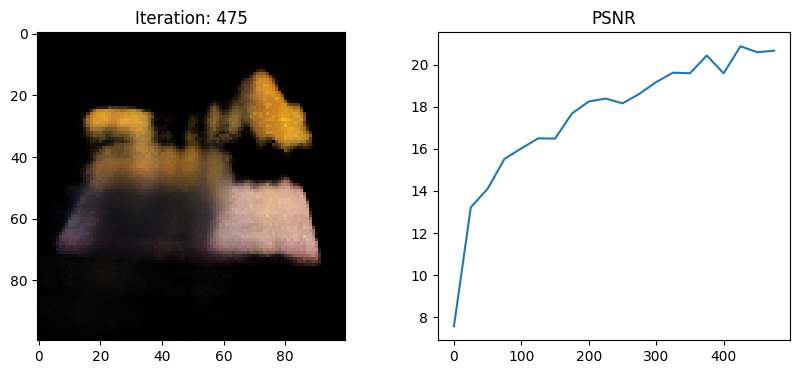

500 2.8090821075439454 secs per iter


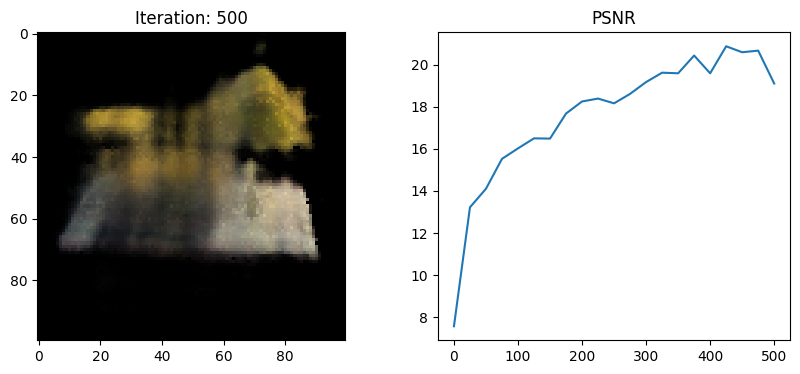

525 2.7702082347869874 secs per iter


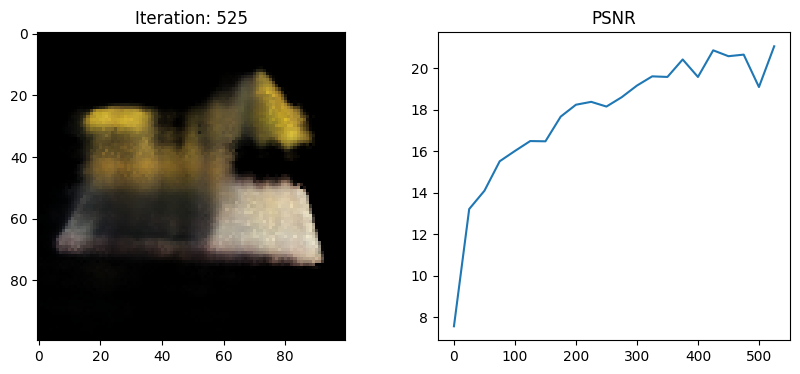

550 2.7838480186462404 secs per iter


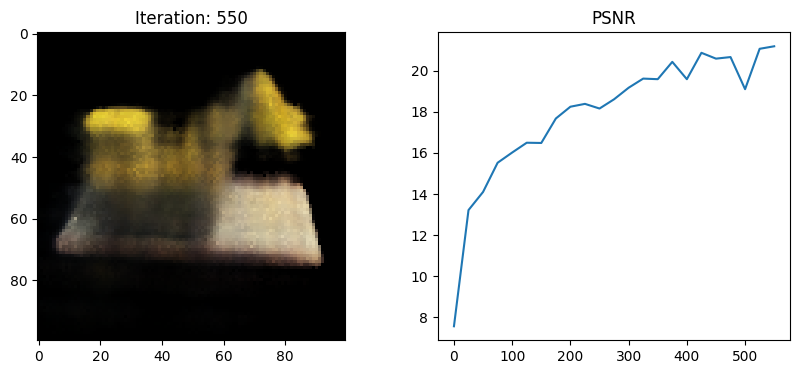

575 2.7761726856231688 secs per iter


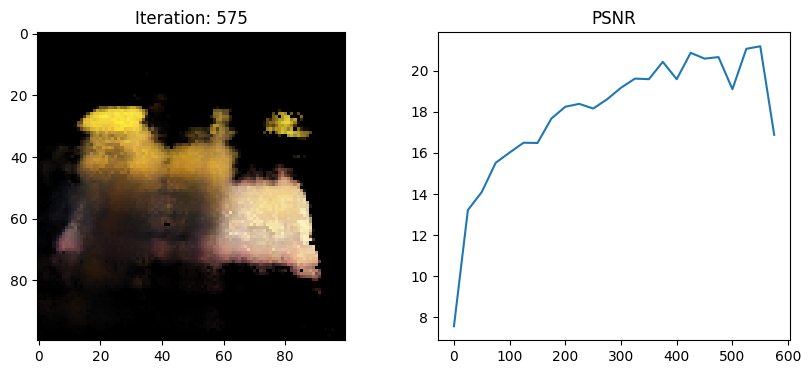

600 2.827542486190796 secs per iter


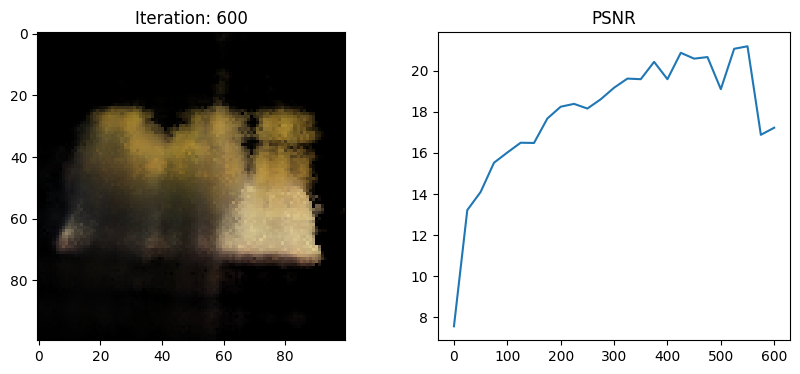

625 2.785122537612915 secs per iter


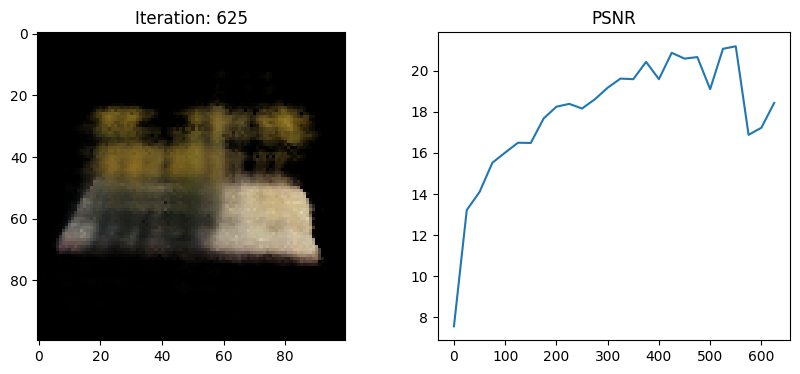

650 2.7976332473754884 secs per iter


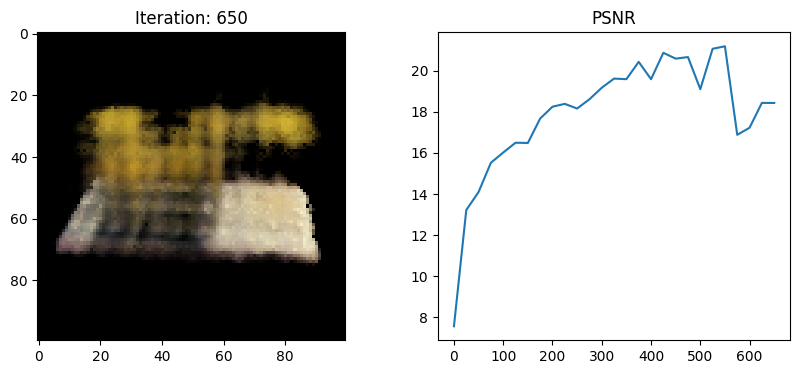

675 2.7847616195678713 secs per iter


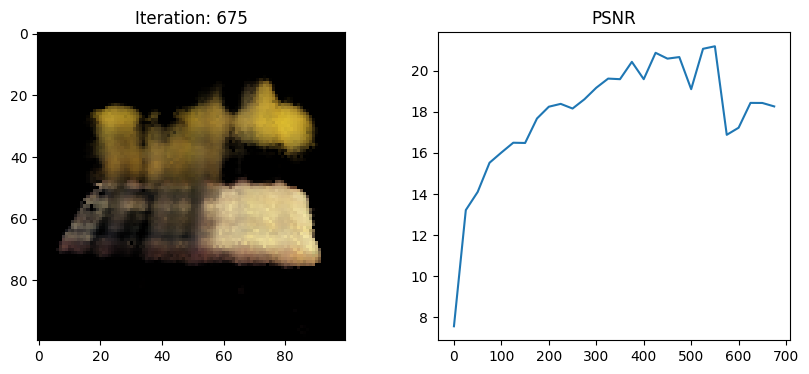

700 2.7821513175964356 secs per iter


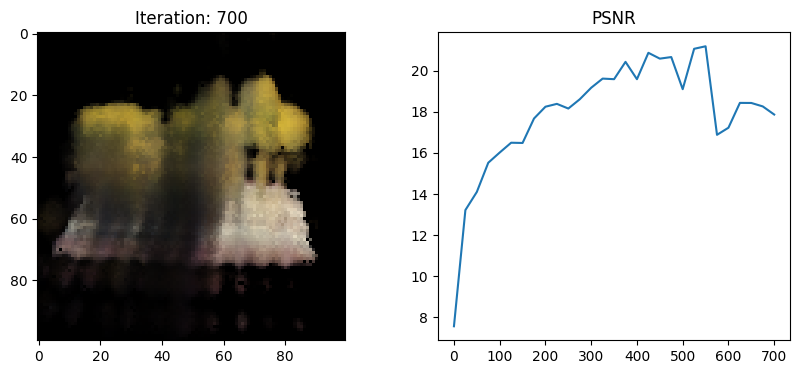

725 2.750741481781006 secs per iter


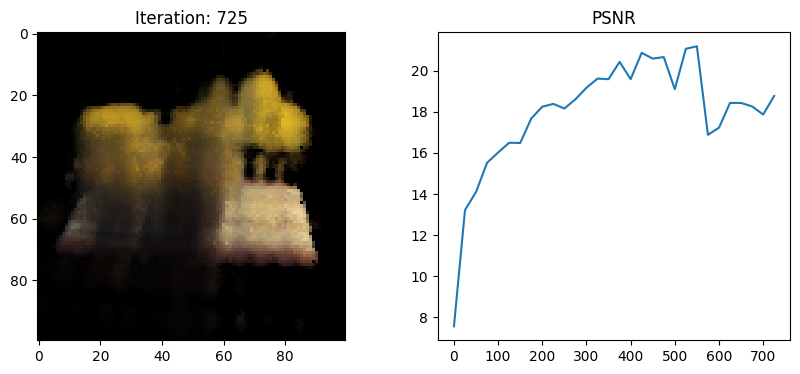

750 2.828337688446045 secs per iter


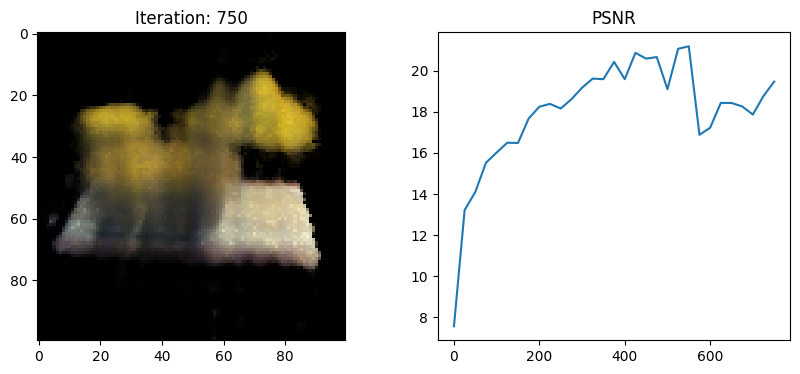

775 2.759449977874756 secs per iter


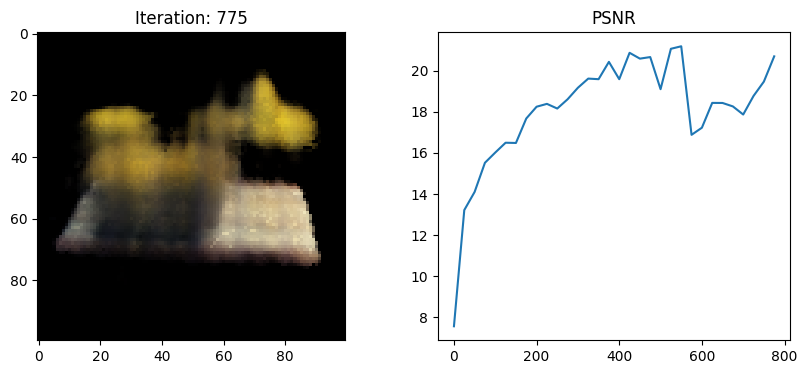

800 2.801631383895874 secs per iter


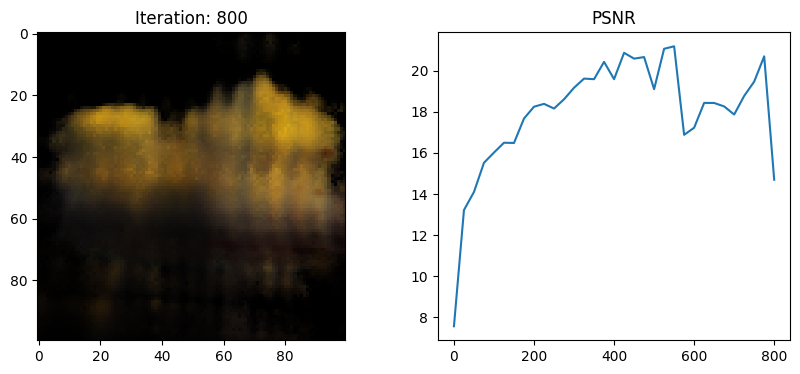

825 2.7670630168914796 secs per iter


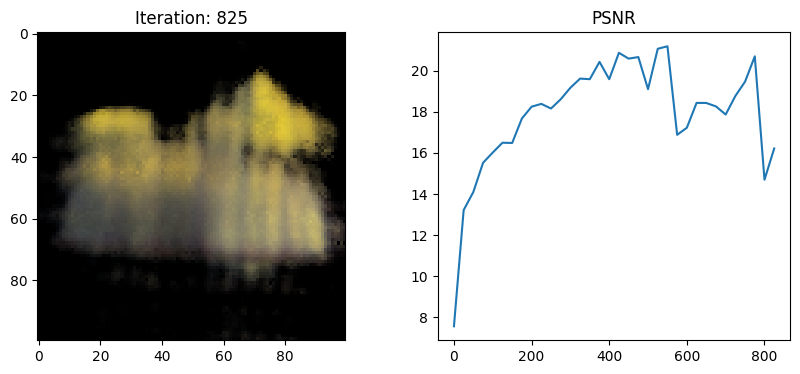

850 2.777173480987549 secs per iter


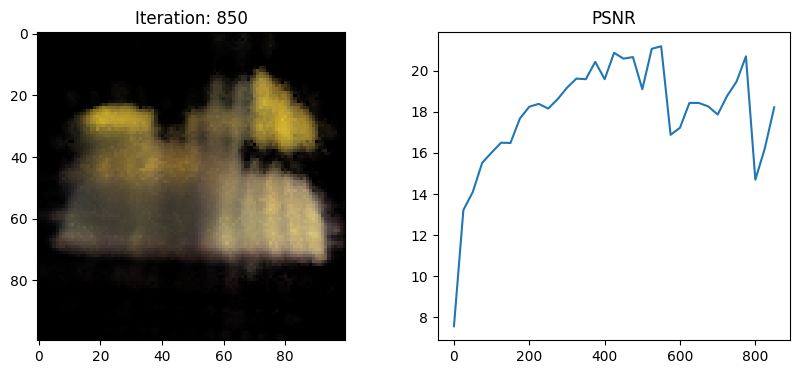

875 2.741493988037109 secs per iter


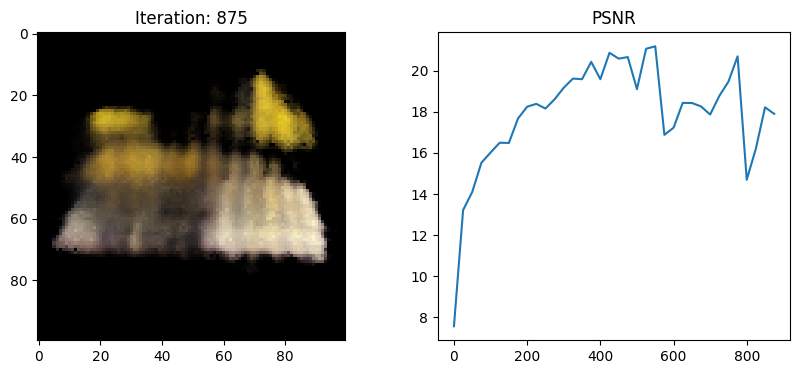

900 2.753608741760254 secs per iter


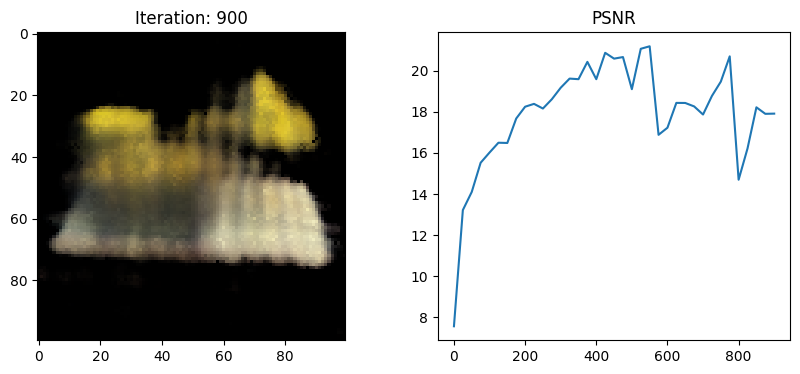

925 2.7873108196258545 secs per iter


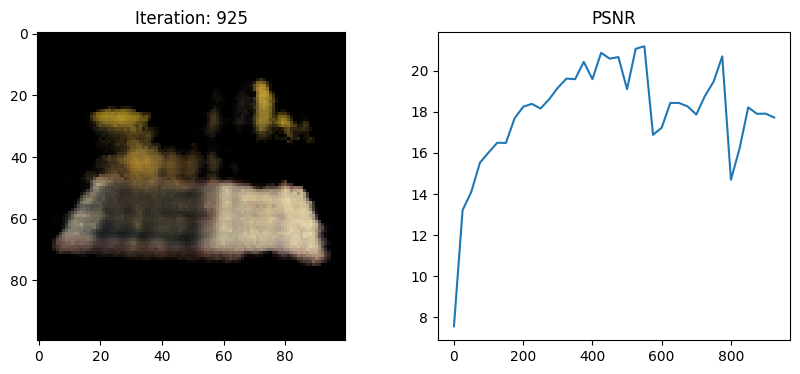

950 2.757655439376831 secs per iter


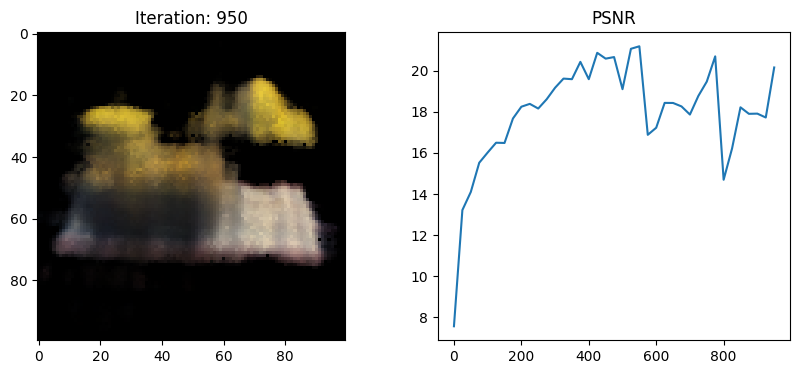

975 2.758467950820923 secs per iter


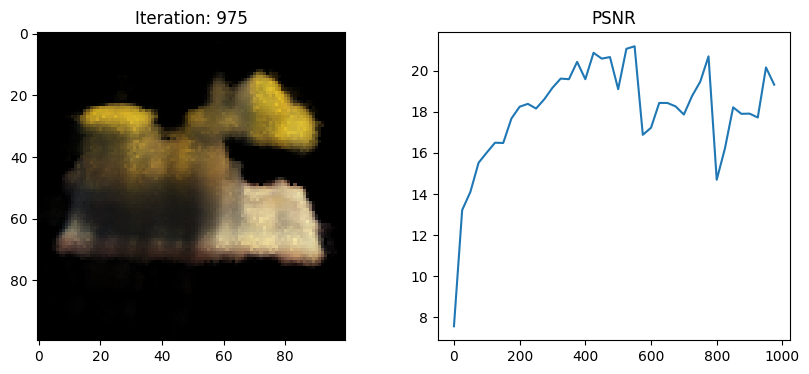

1000 2.7797297763824464 secs per iter


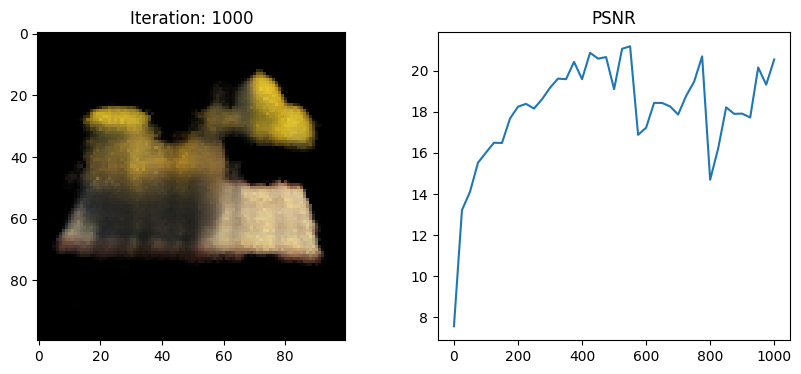

Done


In [6]:
model = init_model(D=8, W=256, L_embed=L_embed)
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 32
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25
batch_size=64*64
N_importance = 16 # Define the number of fine samples you want to use

t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, embed_fn, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size, N_importance=N_importance, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, embed_fn, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size, N_importance=N_importance, rand=True)

        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

In [7]:


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, embed_fn, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size, N_importance=N_importance, rand=True)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, embed_fn, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size, N_importance=N_importance, rand=True)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))


<ipython-input-7-1249b8c9777d>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [8]:
f = 'mlp_base.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

mp4 = open('mlp_base.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)